# Лабораторная работа № 4

Задание:
1. Модель должна научиться классифицировать текст
2. Должны выполнены три реализации модели. Реализации должны быть основаны на использовании:
    - одномерной сверточной нейросети
    - рекуррентной нейросети LSTM
    - рекуррентной нейросети GRU
3. Выполнить сравнение полученных результатов и сделать вывод

Исходные данные:
- для обучения: https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv
- для тестирования: https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv
- имена классов: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt

# Импорт необходимых библиотек

In [2]:
import random  # Импорт модуля random для работы со случайными числами
from scipy.sparse import csr_matrix  # Импорт csr_matrix для работы с разреженными матрицами
import pandas as pd  # Импортируем библиотеку pandas для работы с данными в формате DataFrame
from sklearn.feature_extraction.text import TfidfVectorizer  # Импортируем TfidfVectorizer для преобразования текста в TF-IDF векторы
from sklearn.model_selection import train_test_split  # Импортируем функцию для разделения данных на обучающие и тестовые наборы
from sklearn.preprocessing import LabelEncoder  # Импортируем LabelEncoder для кодирования меток классов
import matplotlib.pyplot as plt  # Импортируем библиотеку для построения графиков
import tensorflow as tf
from tensorflow.keras.models import Sequential  # Импортируем Sequential для создания последовательной модели
from tensorflow.keras.layers import Dense, Dropout  # Импортируем слои Dense и Dropout для создания полносвязных слоев
from tensorflow.keras.callbacks import EarlyStopping  # Импортируем EarlyStopping для остановки обучения при отсутствии улучшений
from tensorflow.keras.optimizers import Adam  # Импортируем оптимизатор Adam
from tensorflow.keras.regularizers import l2  # Импортируем регуляризацию L2
import time # Импорт модуля для работы с временем

# Выбор устройства

In [3]:
device_name = tf.test.gpu_device_name()  # Проверка доступности GPU. Возвращает имя устройства GPU, если оно найдено.
if device_name:
    print(f'Использование GPU: {device_name}')  # Если GPU найдено, выводится имя устройства GPU.
else:
    print('GPU не найдено, использование CPU.')  # Если GPU не найдено, выводится сообщение о использовании CPU.


GPU не найдено, использование CPU.


# Загрузка и подготовка данных

В данном варианте добавлена аугментация - получение дополнитльых данных при помощи удаления случайных слов из текста, перестановки случайных слов в тексте, а также вставки случайных слов в текст. 

In [4]:
# Загрузка данных из локальных файлов
train_df = pd.read_csv('train.csv', header=None)  # Загрузка обучающего набора данных из файла train.csv
test_df = pd.read_csv('test.csv', header=None)  # Загрузка тестового набора данных из файла test.csv

# Назначение имен колонкам
train_df.columns = ['class', 'title', 'description']  # Назначение имен колонкам обучающего набора данных
test_df.columns = ['class', 'title', 'description']  # Назначение имен колонкам тестового набора данных

# Проверка загруженных данных
print(train_df.head())  # Вывод первых нескольких строк обучающего набора данных для проверки

# Функция для удаления случайных слов из текста
def delete_random_words(text, p=0.1):
    words = text.split()  # Разделение текста на слова
    new_words = [word for word in words if random.random() > p]  # Удаление случайных слов с вероятностью p
    return ' '.join(new_words)  # Объединение слов обратно в строку

# Функция для перестановки случайных слов в тексте
def swap_random_words(text, n=1):
    words = text.split()  # Разделение текста на слова
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)  # Выбор двух случайных индексов
        words[idx1], words[idx2] = words[idx2], words[idx1]  # Перестановка слов
    return ' '.join(words)  # Объединение слов обратно в строку

# Функция для вставки случайных слов в текст
def insert_random_words(text, random_words, n=1):
    words = text.split()  # Разделение текста на слова
    for _ in range(n):
        idx = random.randint(0, len(words))  # Выбор случайного индекса для вставки слова
        word = random.choice(random_words)  # Выбор случайного слова из списка
        words.insert(idx, word)  # Вставка слова в текст
    return ' '.join(words)  # Объединение слов обратно в строку

# Пример использования альтернативных методов аугментации
texts = train_df['description'].tolist()  # Преобразование столбца 'description' в список текстов
random_words = ["пример", "текст", "добавка"]  # Список случайных слов для вставки

augmented_texts = []
for text in texts:
    augmented_texts.append(delete_random_words(text, p=0.1))  # Аугментация удалением случайных слов
    augmented_texts.append(swap_random_words(text, n=2))  # Аугментация перестановкой случайных слов
    augmented_texts.append(insert_random_words(text, random_words, n=2))  # Аугментация вставкой случайных слов

# Создание нового DataFrame с аугментированными данными
augmented_df = pd.DataFrame({
    'class': train_df['class'].repeat(3).values,  # Повторение меток классов для аугментированных данных
    'title': train_df['title'].repeat(3).values,  # Повторение заголовков для аугментированных данных
    'description': augmented_texts  # Аугментированные описания
})

# Объединение оригинального и аугментированного наборов данных
augmented_train_df = pd.concat([train_df, augmented_df], ignore_index=True)  # Объединение DataFrame с аугментированными и оригинальными данными

# Проверка размеров нового обучающего набора данных
print(f'Размеры augmented_train_df: {augmented_train_df.shape}')  # Вывод размеров объединенного DataFrame

# Объединение обучающего и тестового наборов данных для преобразования с TF-IDF
all_texts = pd.concat([augmented_train_df['description'], test_df['description']])  # Объединение текстов из обучающего и тестового наборов данных

# Создание TF-IDF векторизатора с уменьшенным количеством признаков
tfidf = TfidfVectorizer(max_features=10000)  # Ограничение количества признаков до 10000

# Преобразование всех текстов
tfidf.fit(all_texts)  # Обучение TF-IDF векторизатора на объединенном наборе текстов

# Преобразование данных
X_train_tfidf = tfidf.transform(augmented_train_df['description'])  # Преобразование обучающего набора данных в TF-IDF векторы
X_test_tfidf = tfidf.transform(test_df['description'])  # Преобразование тестового набора данных в TF-IDF векторы

# Преобразование в форматы разреженных матриц для модели
X_train_tfidf = csr_matrix(X_train_tfidf)  # Преобразование обучающего набора данных в разреженную матрицу
X_test_tfidf = csr_matrix(X_test_tfidf)  # Преобразование тестового набора данных в разреженную матрицу

# Кодирование меток классов
label_encoder = LabelEncoder()  # Создание экземпляра LabelEncoder
y_train = label_encoder.fit_transform(augmented_train_df['class'])  # Кодирование меток классов обучающего набора данных
y_test = label_encoder.transform(test_df['class'])  # Кодирование меток классов тестового набора данных

# Преобразование меток классов в one-hot encoding
y_train = pd.get_dummies(y_train).values  # Преобразование меток классов в one-hot encoding для обучающего набора данных
y_test = pd.get_dummies(y_test).values  # Преобразование меток классов в one-hot encoding для тестового набора данных

# Проверка размеров преобразованных данных
print(f'Размеры X_train_tfidf: {X_train_tfidf.shape}')  # Вывод размеров обучающего набора данных
print(f'Размеры X_test_tfidf: {X_test_tfidf.shape}')  # Вывод размеров тестового набора данных
print(f'Размеры y_train: {y_train.shape}')  # Вывод размеров меток классов обучающего набора данных
print(f'Размеры y_test: {y_test.shape}')  # Вывод размеров меток классов тестового набора данных



   class                                              title  \
0      3  Wall St. Bears Claw Back Into the Black (Reuters)   
1      3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3      3  Iraq Halts Oil Exports from Main Southern Pipe...   
4      3  Oil prices soar to all-time record, posing new...   

                                         description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  
Размеры augmented_train_df: (480000, 3)
Размеры X_train_tfidf: (480000, 10000)
Размеры X_test_tfidf: (7600, 10000)
Размеры y_train: (480000, 4)
Размеры y_test: (7600, 4)


# Создание и обучение моделей

# Одномерная Сверточная Нейросеть (CNN)

Одномерные сверточные нейросети (Convolutional Neural Networks, CNN) часто используются для анализа последовательных данных. Они особенно хорошо справляются с задачами, где важны локальные паттерны (например, последовательности слов или символов).

Принцип работы:

Embedding Layer (Слой Встраивания): Преобразует слова в векторы фиксированной размерности.

Conv1D Layer (Сверточный Слой): Применяет фильтры к входным данным, извлекая локальные паттерны. В нашем случае, мы используем 128 фильтров с размером 5.

MaxPooling1D Layer (Слой Подвыборки): Уменьшает размерность данных, выбирая максимум из каждых 5 элементов, чтобы уменьшить шум и сохранить важные признаки.

GlobalMaxPooling1D Layer (Глобальный Слой Подвыборки): Еще больше уменьшает размерность, агрегируя информацию по всей последовательности.

Dense Layer (Полносвязный Слой): Производит классификацию, используя функцию активации softmax для получения вероятностей классов.

Особенности:

Хорошо справляется с локальными паттернами.

Эффективность при работе с большими наборами данных.

In [5]:
# Создание модели последовательной структуры для CNN
model_cnn = Sequential()  # Инициализация последовательной модели

# Добавление первого полносвязного слоя (Dense) с 128 нейронами и функцией активации ReLU
# input_shape задает форму входных данных, равную размеру TF-IDF векторов
model_cnn.add(Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)))

# Добавление слоя Dropout с вероятностью отключения нейронов 0.5 для борьбы с переобучением
model_cnn.add(Dropout(0.5))

# Добавление второго полносвязного слоя (Dense) с 64 нейронами и функцией активации ReLU
# kernel_regularizer=l2(0.01) добавляет L2 регуляризацию с коэффициентом 0.01 для уменьшения переобучения
model_cnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

# Добавление слоя Dropout с вероятностью отключения нейронов 0.5 для борьбы с переобучением
model_cnn.add(Dropout(0.5))

# Определение количества классов для выходного слоя
num_classes = y_train.shape[1]

# Добавление выходного слоя (Dense) с количеством нейронов, равным количеству классов
# Функция активации softmax используется для многоклассовой классификации
model_cnn.add(Dense(num_classes, activation='softmax'))

# Компиляция модели
# optimizer=Adam - использование оптимизатора Adam для ускорения и стабильности обучения
# loss='categorical_crossentropy' - функция потерь категорическая перекрестная энтропия для многоклассовой классификации
# metrics=['accuracy'] - метрика точности для оценки производительности модели
model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Настройка Early Stopping
# monitor='val_loss' - отслеживание функции потерь на валидационном наборе данных
# patience=2 - количество эпох без улучшений перед остановкой обучения
# restore_best_weights=True - восстановление весов модели с наилучшими показателями производительности
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Обучение модели
# X_train_tfidf - обучающий набор данных в формате TF-IDF
# y_train - метки классов обучающего набора данных
# epochs=50 - максимальное количество эпох обучения
# batch_size=32 - размер пакета для градиентного спуска
# validation_split=0.2 - доля валидационного набора данных для оценки на каждом шаге обучения
# callbacks=[early_stopping] - использование колбэков для Early Stopping
start_time = time.time()
history_cnn = model_cnn.fit(X_train_tfidf, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
cnn_time = time.time() - start_time  # Вычисление времени обучения модели CNN


C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.8702 - loss: 0.4742 - val_accuracy: 0.9206 - val_loss: 0.2625
Epoch 2/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 76s 6ms/step - accuracy: 0.9391 - loss: 0.2212 - val_accuracy: 0.9290 - val_loss: 0.2457
Epoch 3/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - accuracy: 0.9548 - loss: 0.1745 - val_accuracy: 0.9357 - val_loss: 0.2359
Epoch 4/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.9639 - loss: 0.1468 - val_accuracy: 0.9432 - val_loss: 0.2166
Epoch 5/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - accuracy: 0.9693 - loss: 0.1297 - val_accuracy: 0.9488 - val_loss: 0.2076


In [8]:
# Оценка модели CNN на тестовом наборе данных
# X_test_tfidf - тестовый набор данных в формате TF-IDF
# y_test - метки классов тестового набора данных
cnn_loss, cnn_acc = model_cnn.evaluate(X_test_tfidf, y_test, verbose=0)  # Оценка модели CNN на тестовом наборе данных
# model_cnn.evaluate возвращает два значения: потери и точность. Здесь мы присваиваем их переменным cnn_loss и cnn_acc.

# Вывод результатов оценки для модели CNN
print(f'Точность на тестовых данных с CNN: {cnn_acc*100:.2f}%')  # Вывод точности модели на тестовых данных в процентах
print(f'Потери на тестовых данных с CNN: {cnn_loss:.4f}')  # Вывод потерь модели на тестовых данных



Точность на тестовых данных с CNN: 90.79%
Потери на тестовых данных с CNN: 0.4493


# Рекуррентная Нейросеть LSTM

LSTM (Long Short-Term Memory) - это разновидность рекуррентных нейросетей, которые могут обучаться и запоминать долгосрочные зависимости в последовательных данных, что делает их полезными для задач, где важен порядок и контекст.

Принцип работы:

Embedding Layer (Слой Встраивания): Преобразует слова в векторы фиксированной размерности.

LSTM Layer: Специально разработан для запоминания долгосрочных зависимостей в данных. Содержит ячейки памяти, которые могут сохранять информацию на долгое время.

Dense Layer (Полносвязный Слой): Производит классификацию, используя функцию активации softmax для получения вероятностей классов.

Особенности:

Способность запоминать и учитывать долгосрочные зависимости и контексты.

Эффективность в задачах, где важен порядок элементов, например, в анализе текста или временных рядов.

In [9]:
# Создание модели последовательной структуры для LSTM
model_lstm = Sequential()  # Инициализация последовательной модели

# Добавление первого полносвязного слоя (Dense) с 128 нейронами и функцией активации ReLU
# input_shape задает форму входных данных, равную размеру TF-IDF векторов
model_lstm.add(Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)))

# Добавление слоя Dropout с вероятностью отключения нейронов 0.5 для борьбы с переобучением
model_lstm.add(Dropout(0.5))

# Добавление второго полносвязного слоя (Dense) с 64 нейронами и функцией активации ReLU
# kernel_regularizer=l2(0.01) добавляет L2 регуляризацию с коэффициентом 0.01 для уменьшения переобучения
model_lstm.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

# Добавление слоя Dropout с вероятностью отключения нейронов 0.5 для борьбы с переобучением
model_lstm.add(Dropout(0.5))

# Добавление выходного слоя (Dense) с количеством нейронов, равным количеству классов
# Функция активации softmax используется для многоклассовой классификации
model_lstm.add(Dense(num_classes, activation='softmax'))

# Компиляция модели
# optimizer=Adam - использование оптимизатора Adam для ускорения и стабильности обучения
# loss='categorical_crossentropy' - функция потерь категорическая перекрестная энтропия для многоклассовой классификации
# metrics=['accuracy'] - метрика точности для оценки производительности модели
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Настройка Early Stopping
# monitor='val_loss' - отслеживание функции потерь на валидационном наборе данных
# patience=2 - количество эпох без улучшений перед остановкой обучения
# restore_best_weights=True - восстановление весов модели с наилучшими показателями производительности
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Обучение модели
# X_train_tfidf - обучающий набор данных в формате TF-IDF
# y_train - метки классов обучающего набора данных
# epochs=50 - максимальное количество эпох обучения
# batch_size=32 - размер пакета для градиентного спуска
# validation_split=0.2 - доля валидационного набора данных для оценки на каждом шаге обучения
# callbacks=[early_stopping] - использование колбэков для Early Stopping
start_time = time.time()
history_lstm = model_lstm.fit(X_train_tfidf, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
lstm_time = time.time() - start_time  # Вычисление времени обучения модели LSTM

Epoch 1/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.8704 - loss: 0.4726 - val_accuracy: 0.9200 - val_loss: 0.2619
Epoch 2/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.9396 - loss: 0.2190 - val_accuracy: 0.9282 - val_loss: 0.2490
Epoch 3/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.9540 - loss: 0.1757 - val_accuracy: 0.9359 - val_loss: 0.2388
Epoch 4/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - accuracy: 0.9623 - loss: 0.1501 - val_accuracy: 0.9425 - val_loss: 0.2246
Epoch 5/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - accuracy: 0.9692 - loss: 0.1315 - val_accuracy: 0.9478 - val_loss: 0.2013


In [10]:
# Оценка модели LSTM на тестовом наборе данных
# X_test_tfidf - тестовый набор данных в формате TF-IDF
# y_test - метки классов тестового набора данных
lstm_loss, lstm_acc = model_lstm.evaluate(X_test_tfidf, y_test, verbose=0)  # Оценка модели LSTM на тестовом наборе данных

# Вывод результатов оценки для модели LSTM
print(f'Точность на тестовых данных с LSTM: {lstm_acc*100:.2f}%')  # Вывод точности модели на тестовых данных в процентах
print(f'Потери на тестовых данных с LSTM: {lstm_loss:.4f}')  # Вывод потерь модели на тестовых данных


Точность на тестовых данных с LSTM: 90.55%
Потери на тестовых данных с LSTM: 0.4045


# Рекуррентная Нейросеть GRU

GRU (Gated Recurrent Unit) - это разновидность рекуррентных нейросетей, аналогичная LSTM, но с упрощенной архитектурой. GRU также эффективны для запоминания долгосрочных зависимостей.

Принцип работы:

Embedding Layer (Слой Встраивания): Преобразует слова в векторы фиксированной размерности.

GRU Layer: Упрощенная версия LSTM с меньшим количеством параметров. Может запоминать долгосрочные зависимости, используя механизмы затворов.

Dense Layer (Полносвязный Слой): Производит классификацию, используя функцию активации softmax для получения вероятностей классов.

Особенности:

Упрощенная архитектура по сравнению с LSTM, что может привести к более быстрому обучению.

Эффективность в задачах, где важен порядок и контекст данных.

In [11]:
# Создание модели последовательной структуры для GRU
model_gru = Sequential()  # Инициализация последовательной модели

# Добавление первого полносвязного слоя (Dense) с 128 нейронами и функцией активации ReLU
# input_shape задает форму входных данных, равную размеру TF-IDF векторов
model_gru.add(Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)))

# Добавление слоя Dropout с вероятностью отключения нейронов 0.5 для борьбы с переобучением
model_gru.add(Dropout(0.5))

# Добавление второго полносвязного слоя (Dense) с 64 нейронами и функцией активации ReLU
# kernel_regularizer=l2(0.01) добавляет L2 регуляризацию с коэффициентом 0.01 для уменьшения переобучения
model_gru.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

# Добавление слоя Dropout с вероятностью отключения нейронов 0.5 для борьбы с переобучением
model_gru.add(Dropout(0.5))

# Добавление выходного слоя (Dense) с количеством нейронов, равным количеству классов
# Функция активации softmax используется для многоклассовой классификации
model_gru.add(Dense(num_classes, activation='softmax'))

# Компиляция модели
# optimizer=Adam - использование оптимизатора Adam для ускорения и стабильности обучения
# loss='categorical_crossentropy' - функция потерь категорическая перекрестная энтропия для многоклассовой классификации
# metrics=['accuracy'] - метрика точности для оценки производительности модели
model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Настройка Early Stopping
# monitor='val_loss' - отслеживание функции потерь на валидационном наборе данных
# patience=2 - количество эпох без улучшений перед остановкой обучения
# restore_best_weights=True - восстановление весов модели с наилучшими показателями производительности
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Обучение модели
# X_train_tfidf - обучающий набор данных в формате TF-IDF
# y_train - метки классов обучающего набора данных
# epochs=50 - максимальное количество эпох обучения
# batch_size=32 - размер пакета для градиентного спуска
# validation_split=0.2 - доля валидационного набора данных для оценки на каждом шаге обучения
# callbacks=[early_stopping] - использование колбэков для Early Stopping
start_time = time.time()
history_gru = model_gru.fit(X_train_tfidf, y_train, epochs=5, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
gru_time = time.time() - start_time  # Вычисление времени обучения модели GRU



Epoch 1/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 83s 7ms/step - accuracy: 0.8718 - loss: 0.4730 - val_accuracy: 0.9191 - val_loss: 0.2627
Epoch 2/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.9403 - loss: 0.2172 - val_accuracy: 0.9280 - val_loss: 0.2559
Epoch 3/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.9547 - loss: 0.1760 - val_accuracy: 0.9344 - val_loss: 0.2422
Epoch 4/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 76s 6ms/step - accuracy: 0.9636 - loss: 0.1492 - val_accuracy: 0.9409 - val_loss: 0.2115
Epoch 5/5
12000/12000 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - accuracy: 0.9694 - loss: 0.1308 - val_accuracy: 0.9481 - val_loss: 0.2067


In [12]:
# Оценка модели GRU на тестовом наборе данных
# X_test_tfidf - тестовый набор данных в формате TF-IDF
# y_test - метки классов тестового набора данных
gru_loss, gru_acc = model_gru.evaluate(X_test_tfidf, y_test, verbose=0)  # Оценка модели GRU на тестовом наборе данных

# Вывод результатов оценки для модели GRU
print(f'Точность на тестовых данных с GRU: {gru_acc*100:.2f}%')  # Вывод точности модели на тестовых данных в процентах
print(f'Потери на тестовых данных с GRU: {gru_loss:.4f}')  # Вывод потерь модели на тестовых данных




Точность на тестовых данных с GRU: 90.42%
Потери на тестовых данных с GRU: 0.4265


# Оценка моделей и сравнение результатов

# Точность

Точность (accuracy) – это метрика, показывающая долю правильных предсказаний модели от общего числа предсказаний. Она особенно полезна в задачах классификации и определяется как отношение числа верно предсказанных классов к общему числу примеров.

In [13]:
# Оценка точности моделей на тестовом наборе данных
cnn_acc = model_cnn.evaluate(X_test_tfidf, y_test, verbose=0)[1]  # Оценка точности модели CNN на тестовом наборе данных
lstm_acc = model_lstm.evaluate(X_test_tfidf, y_test, verbose=0)[1]  # Оценка точности модели LSTM на тестовом наборе данных
gru_acc = model_gru.evaluate(X_test_tfidf, y_test, verbose=0)[1]  # Оценка точности модели GRU на тестовом наборе данных

# Функция для вывода итоговой точности моделей
def print_final_accuracies(model_name, train_acc, val_acc, test_acc):
    print(f'\n{model_name}')  # Вывод названия модели
    print(f'Точность на обучении: {train_acc:.2f}')  # Вывод точности модели на обучающих данных
    print(f'Точность на валидации: {val_acc:.2f}')  # Вывод точности модели на данных валидации
    print(f'Точность на тесте: {test_acc:.2f}')  # Вывод точности модели на тестовых данных

# Вывод точности моделей CNN, LSTM и GRU
cnn_train_acc = history_cnn.history['accuracy'][-1]  # Последнее значение точности на обучающих данных для модели CNN
cnn_val_acc = history_cnn.history['val_accuracy'][-1]  # Последнее значение точности на данных валидации для модели CNN
print_final_accuracies('CNN', cnn_train_acc, cnn_val_acc, cnn_acc)  # Вывод итоговой точности модели CNN

lstm_train_acc = history_lstm.history['accuracy'][-1]  # Последнее значение точности на обучающих данных для модели LSTM
lstm_val_acc = history_lstm.history['val_accuracy'][-1]  # Последнее значение точности на данных валидации для модели LSTM
print_final_accuracies('LSTM', lstm_train_acc, lstm_val_acc, lstm_acc)  # Вывод итоговой точности модели LSTM

gru_train_acc = history_gru.history['accuracy'][-1]  # Последнее значение точности на обучающих данных для модели GRU
gru_val_acc = history_gru.history['val_accuracy'][-1]  # Последнее значение точности на данных валидации для модели GRU
print_final_accuracies('GRU', gru_train_acc, gru_val_acc, gru_acc)  # Вывод итоговой точности модели GRU





CNN
Точность на обучении: 0.97
Точность на валидации: 0.95
Точность на тесте: 0.91

LSTM
Точность на обучении: 0.97
Точность на валидации: 0.95
Точность на тесте: 0.91

GRU
Точность на обучении: 0.97
Точность на валидации: 0.95
Точность на тесте: 0.90


# Потери

Функция categorical_crossentropy (категориальная кросс-энтропия) используется для многоклассовой классификации. Она измеряет разницу между истинным распределением классов (целевыми метками) и предсказанным распределением классов (выходом модели).

In [14]:
# Оценка потерь моделей на тестовом наборе данных
cnn_loss = model_cnn.evaluate(X_test_tfidf, y_test, verbose=0)[0]  # Оценка потерь модели CNN на тестовом наборе данных
lstm_loss = model_lstm.evaluate(X_test_tfidf, y_test, verbose=0)[0]  # Оценка потерь модели LSTM на тестовом наборе данных
gru_loss = model_gru.evaluate(X_test_tfidf, y_test, verbose=0)[0]  # Оценка потерь модели GRU на тестовом наборе данных

# Функция для вывода итоговых потерь моделей
def print_final_losses(model_name, train_loss, val_loss, test_loss):
    print(f'\n{model_name}')  # Вывод названия модели
    print(f'Потери на обучении: {train_loss:.4f}')  # Вывод потерь модели на обучающих данных
    print(f'Потери на валидации: {val_loss:.4f}')  # Вывод потерь модели на данных валидации
    print(f'Потери на тесте: {test_loss:.4f}')  # Вывод потерь модели на тестовых данных

# Вывод потерь моделей CNN, LSTM и GRU
cnn_train_loss = history_cnn.history['loss'][-1]  # Последнее значение потерь на обучающих данных для модели CNN
cnn_val_loss = history_cnn.history['val_loss'][-1]  # Последнее значение потерь на данных валидации для модели CNN
print_final_losses('CNN', cnn_train_loss, cnn_val_loss, cnn_loss)  # Вывод итоговых потерь модели CNN

lstm_train_loss = history_lstm.history['loss'][-1]  # Последнее значение потерь на обучающих данных для модели LSTM
lstm_val_loss = history_lstm.history['val_loss'][-1]  # Последнее значение потерь на данных валидации для модели LSTM
print_final_losses('LSTM', lstm_train_loss, lstm_val_loss, lstm_loss)  # Вывод итоговых потерь модели LSTM

gru_train_loss = history_gru.history['loss'][-1]  # Последнее значение потерь на обучающих данных для модели GRU
gru_val_loss = history_gru.history['val_loss'][-1]  # Последнее значение потерь на данных валидации для модели GRU
print_final_losses('GRU', gru_train_loss, gru_val_loss, gru_loss)  # Вывод итоговых потерь модели GRU




CNN
Потери на обучении: 0.1321
Потери на валидации: 0.2076
Потери на тесте: 0.4493

LSTM
Потери на обучении: 0.1322
Потери на валидации: 0.2013
Потери на тесте: 0.4045

GRU
Потери на обучении: 0.1321
Потери на валидации: 0.2067
Потери на тесте: 0.4265


# Построение графиков

Точность и потери

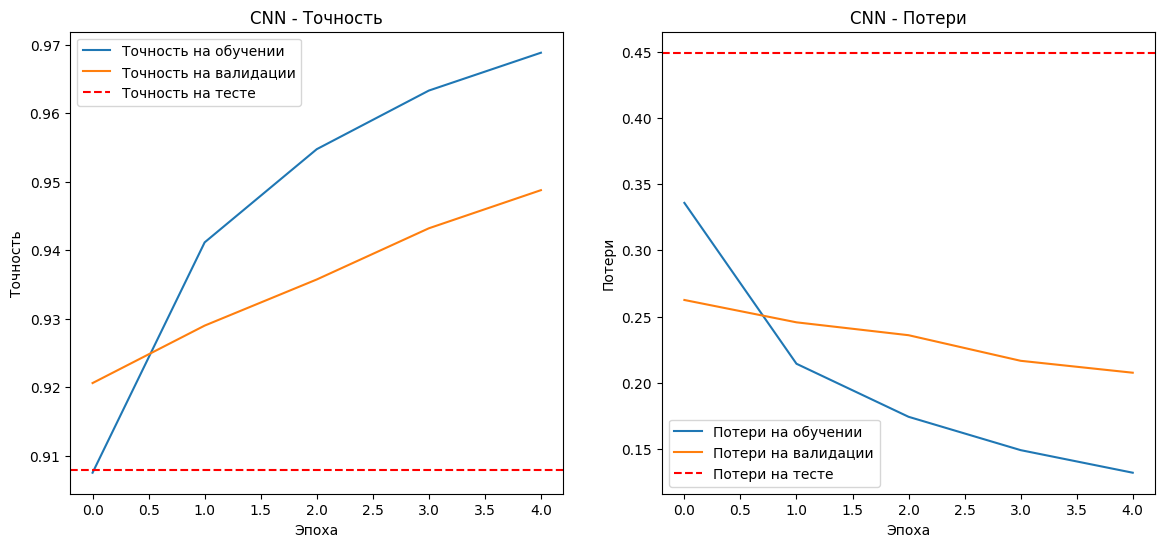

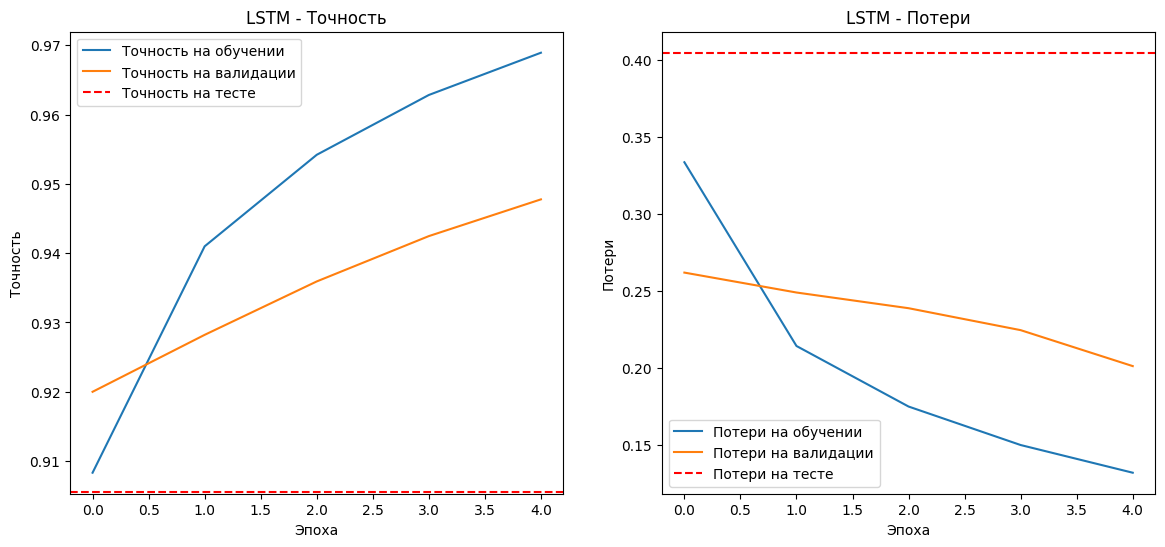

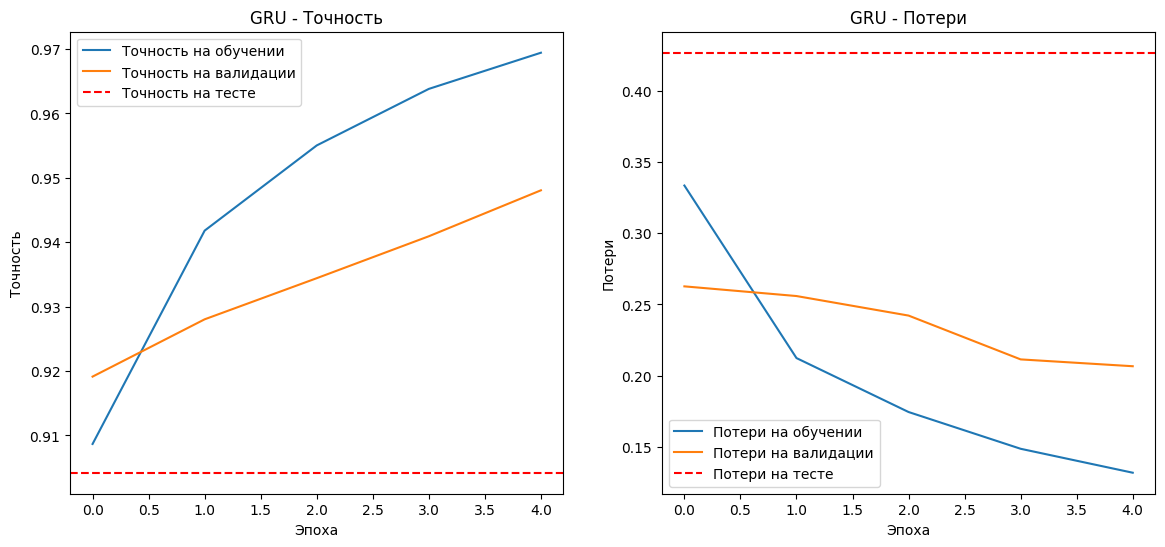

In [15]:
# Функция для построения графиков обучения и потерь
def plot_full_training_history(history, model_name, test_acc, test_loss):
    plt.figure(figsize=(14, 6))

    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Точность на обучении')
    plt.plot(history.history['val_accuracy'], label='Точность на валидации')
    plt.axhline(y=test_acc, color='r', linestyle='--', label='Точность на тесте')
    plt.title(f'{model_name} - Точность')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Потери на обучении')
    plt.plot(history.history['val_loss'], label='Потери на валидации')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Потери на тесте')
    plt.title(f'{model_name} - Потери')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()

    # Отображение графиков
    plt.show()

# Построение графиков для каждой модели
plot_full_training_history(history_cnn, 'CNN', cnn_acc, cnn_loss)
plot_full_training_history(history_lstm, 'LSTM', lstm_acc, lstm_loss)
plot_full_training_history(history_gru, 'GRU', gru_acc, gru_loss)





Время обучения

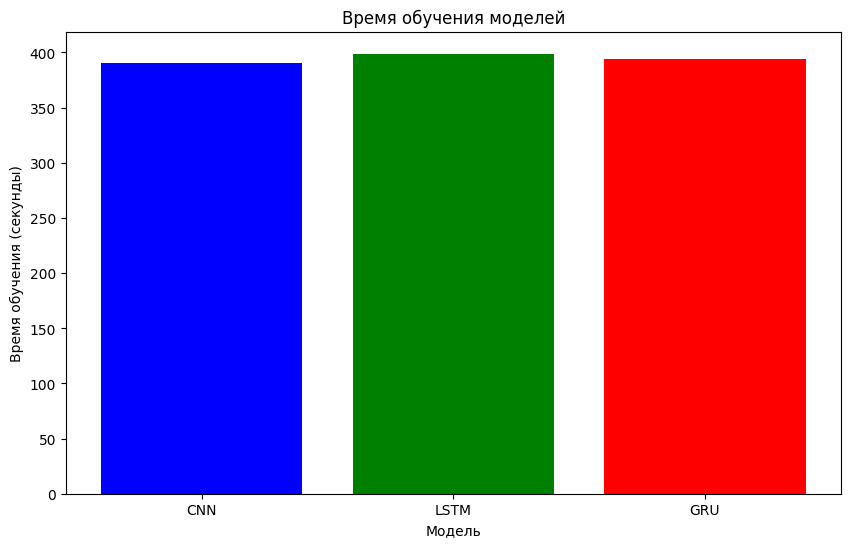

In [ ]:
# Построение графика времени обучения
models = ['CNN', 'LSTM', 'GRU']  # Названия моделей для оси X
training_times = [cnn_time, lstm_time, gru_time]  # Времена обучения каждой модели (в секундах)

plt.figure(figsize=(10, 6))  # Создание фигуры размером 10x6 дюймов для графика

# Построение столбчатого графика
plt.bar(models, training_times, color=['blue', 'green', 'red'])  # Построение столбиков графика с указанием цветов для каждой модели

# Установка меток осей
plt.xlabel('Модель')  # Установка метки оси X с текстом "Модель"
plt.ylabel('Время обучения (секунды)')  # Установка метки оси Y с текстом "Время обучения (секунды)"

# Установка заголовка графика
plt.title('Время обучения моделей')  # Установка заголовка графика с текстом "Время обучения моделей"

plt.show()  # Отображение графика на экране


# Выводы:
Добавление аугментации данных ухудшает результаты на тестовом наборе данных.